In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform

if platform.system() == 'Darwin': #맥
        plt.rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': #윈도우
        plt.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Linux': #리눅스 (구글 콜랩)
        plt.rc('font', family='Malgun Gothic') 
        
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [6]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets        import load_iris, load_breast_cancer
#데이터 분류 함수
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, make_scorer, precision_recall_curve
#분류 알고리즘
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression, LinearRegression
from sklearn.impute          import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing   import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

import seaborn as sns
from io import StringIO
import missingno as msno
import matplotlib.pyplot as plt

#군집
from sklearn.cluster import KMeans

### 진행절차
#### step01. 데이터 전처리 - (지역, 코드 , 유형, 주야)
#### step02. 군집모형생성 - 분석에 사용할 피처는 과학고, 외고국제고, 자사고 진학률
#### step03. 표준화
#### step04. 모형 객체 생성
#### step05. 모형 학습
#### step06. 예측
#### step07. 예측 결과를 데이터 프레임에 추가
#### step08. 클러스터 값으로 그룹화, 그룹별 내용 출력
#### step09. 지도 그래프 시각화

#### 고등학교 진학률 데이터를 활용하여 속성이 비슷한 중학교끼리 군집화
- 데이터 인코딩, 지도 시각화 필요(위도, 경도, folium)

- 진학률을 가지고 군집을 만들어 지도에 분류해보자

In [14]:
school_frm = pd.read_excel('data/middle_shcool_graduates_report.xlsx', header=0)
school_frm_ori = school_frm.copy()
school_frm

,Unnamed: 0,지역,학교명,코드,유형,주야,남학생수,여학생수,일반고,특성화고,...,외고_국제고,예고_체고,마이스터고,자사고,자공고,기타진학,취업,미상,위도,경도
0,0,성북구,서울대학교사범대학부설중학교,3,국립,주간,277,0,0.585,0.148,...,0.007,0.000,0.011,0.227,0.000,0.004,0,0.000,37.594942,127.038909
1,1,종로구,서울대학교사범대학부설여자중학교,3,국립,주간,0,256,0.680,0.199,...,0.035,0.008,0.000,0.043,0.004,0.031,0,0.000,37.577473,127.003857
2,2,강남구,개원중학교,3,공립,주간,170,152,0.817,0.047,...,0.012,0.003,0.006,0.090,0.003,0.009,0,0.003,37.491637,127.071744
3,3,강남구,개포중학교,3,공립,주간,83,72,0.755,0.097,...,0.013,0.019,0.019,0.065,0.000,0.019,0,0.000,37.480439,127.062201
4,4,서초구,경원중학교,3,공립,주간,199,212,0.669,0.017,...,0.010,0.005,0.000,0.282,0.000,0.010,0,0.000,37.510750,127.008900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,강남구,국립국악중학교,9,국립,주간,9,91,0.060,0.000,...,0.000,0.940,0.000,0.000,0.000,0.000,0,0.000,37.476381,127.051355
411,411,금천구,국립전통예술중학교,9,국립,주간,14,42,0.107,0.000,...,0.000,0.875,0.000,0.000,0.000,0.000,0,0.018,37.446354,126.906424
412,412,광진구,선화예술학교,9,사립,주간,33,241,0.102,0.000,...,0.000,0.861,0.000,0.000,0.000,0.000,0,0.036,37.549642,127.087737
413,413,중구,예원학교,9,사립,주간,31,258,0.170,0.000,...,0.000,0.751,0.000,0.000,0.000,0.048,0,0.031,37.566951,126.971553


In [15]:
#1번 - 레이블 인코딩

label_encoder = LabelEncoder()
list_a = ['지역', '코드', '유형', '주야']
for i in list_a:
    school_frm[i] = label_encoder.fit_transform(school_frm[i])
school_frm

,Unnamed: 0,지역,학교명,코드,유형,주야,남학생수,여학생수,일반고,특성화고,...,외고_국제고,예고_체고,마이스터고,자사고,자공고,기타진학,취업,미상,위도,경도
0,0,16,서울대학교사범대학부설중학교,0,1,0,277,0,0.585,0.148,...,0.007,0.000,0.011,0.227,0.000,0.004,0,0.000,37.594942,127.038909
1,1,22,서울대학교사범대학부설여자중학교,0,1,0,0,256,0.680,0.199,...,0.035,0.008,0.000,0.043,0.004,0.031,0,0.000,37.577473,127.003857
2,2,0,개원중학교,0,0,0,170,152,0.817,0.047,...,0.012,0.003,0.006,0.090,0.003,0.009,0,0.003,37.491637,127.071744
3,3,0,개포중학교,0,0,0,83,72,0.755,0.097,...,0.013,0.019,0.019,0.065,0.000,0.019,0,0.000,37.480439,127.062201
4,4,14,경원중학교,0,0,0,199,212,0.669,0.017,...,0.010,0.005,0.000,0.282,0.000,0.010,0,0.000,37.510750,127.008900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,0,국립국악중학교,2,1,0,9,91,0.060,0.000,...,0.000,0.940,0.000,0.000,0.000,0.000,0,0.000,37.476381,127.051355
411,411,7,국립전통예술중학교,2,1,0,14,42,0.107,0.000,...,0.000,0.875,0.000,0.000,0.000,0.000,0,0.018,37.446354,126.906424
412,412,5,선화예술학교,2,2,0,33,241,0.102,0.000,...,0.000,0.861,0.000,0.000,0.000,0.000,0,0.036,37.549642,127.087737
413,413,23,예원학교,2,2,0,31,258,0.170,0.000,...,0.000,0.751,0.000,0.000,0.000,0.048,0,0.031,37.566951,126.971553


In [16]:
school_frm.keys()

Index(['Unnamed: 0', '지역', '학교명', '코드', '유형', '주야', '남학생수', '여학생수', '일반고',
       '특성화고', '과학고', '외고_국제고', '예고_체고', '마이스터고', '자사고', '자공고', '기타진학', '취업',
       '미상', '위도', '경도'],
      dtype='object')

In [26]:
#군집에 쓸 피처만 고르기
school_clu_frm = school_frm.copy()
school_clu_frm = school_clu_frm.loc[:, '코드' : '자공고']
school_clu_frm

,코드,유형,주야,남학생수,여학생수,일반고,특성화고,과학고,외고_국제고,예고_체고,마이스터고,자사고,자공고
0,0,1,0,277,0,0.585,0.148,0.018,0.007,0.000,0.011,0.227,0.000
1,0,1,0,0,256,0.680,0.199,0.000,0.035,0.008,0.000,0.043,0.004
2,0,0,0,170,152,0.817,0.047,0.009,0.012,0.003,0.006,0.090,0.003
3,0,0,0,83,72,0.755,0.097,0.013,0.013,0.019,0.019,0.065,0.000
4,0,0,0,199,212,0.669,0.017,0.007,0.010,0.005,0.000,0.282,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,2,1,0,9,91,0.060,0.000,0.000,0.000,0.940,0.000,0.000,0.000
411,2,1,0,14,42,0.107,0.000,0.000,0.000,0.875,0.000,0.000,0.000
412,2,2,0,33,241,0.102,0.000,0.000,0.000,0.861,0.000,0.000,0.000
413,2,2,0,31,258,0.170,0.000,0.000,0.000,0.751,0.000,0.000,0.000


In [27]:
#주성분 분석 진행

school_kmeans = KMeans(n_clusters = 5,
                         verbose    = 1,
                         init       = 'k-means++',  #좀더 상향된 기능으로 센트로이드를 잡는다.
                         max_iter   = 300)          #300회 동안 센터 잡아라.
                     
print((school_kmeans.fit(school_clu_frm)))
print()
print(school_kmeans.labels_)
print()
print(school_kmeans.cluster_centers_)

Initialization complete
Iteration 0, inertia 1361439.5719310006
Iteration 1, inertia 1085862.2687161376
Iteration 2, inertia 1063010.0265984568
Iteration 3, inertia 1060637.7440022943
Iteration 4, inertia 1060430.1776878876
Iteration 5, inertia 1060376.8777037188
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 1851856.1863170043
Iteration 1, inertia 1493569.9924700777
Iteration 2, inertia 1184428.4288106225
Iteration 3, inertia 1087414.368879814
Iteration 4, inertia 1070346.8287102864
Iteration 5, inertia 1063030.8065207265
Iteration 6, inertia 1060858.0643342035
Iteration 7, inertia 1060376.8777037188
Converged at iteration 7: strict convergence.
Initialization complete
Iteration 0, inertia 1151368.5122219992
Iteration 1, inertia 1103238.022995168
Iteration 2, inertia 1092299.1825835556
Iteration 3, inertia 1084993.8416015608
Iteration 4, inertia 1081365.6020591836
Iteration 5, inertia 1080103.075916381
Iteration 6, inertia 1078871.9678536546

In [76]:
#차원 축소 진행
from sklearn.decomposition import PCA
school_pca = PCA(n_components = 2)
school_pca_trans = school_pca.fit_transform(school_clu_frm)

# print(school_pca_trans[ : , 0])
# print("\n" *3)
# print(school_pca_trans[ : , 1])
# school_pca_trans

school_frm['pca_x'] = school_pca_trans[ : , 0]
school_frm['pca_y'] = school_pca_trans[ : , 1]
school_frm['cid'] = school_kmeans.labels_

school_pca_frm = pd.DataFrame(data=school_pca_trans[ : , 0], columns=['pca_x'])
school_pca_frm['pca_y'] = school_pca_trans[ : , 1]
school_frm

,Unnamed: 0,지역,학교명,코드,유형,주야,남학생수,여학생수,일반고,특성화고,...,자사고,자공고,기타진학,취업,미상,위도,경도,pca_x,pca_y,cid
0,0,16,서울대학교사범대학부설중학교,0,1,0,277,0,0.585,0.148,...,0.227,0.000,0.004,0,0.000,37.594942,127.038909,-188.395928,-25.368031,3
1,1,22,서울대학교사범대학부설여자중학교,0,1,0,0,256,0.680,0.199,...,0.043,0.004,0.031,0,0.000,37.577473,127.003857,179.496793,57.817726,2
2,2,0,개원중학교,0,0,0,170,152,0.817,0.047,...,0.090,0.003,0.009,0,0.003,37.491637,127.071744,-19.729065,52.763318,0
3,3,0,개포중학교,0,0,0,83,72,0.755,0.097,...,0.065,0.000,0.019,0,0.000,37.480439,127.062201,15.609388,-60.019490,4
4,4,14,경원중학교,0,0,0,199,212,0.669,0.017,...,0.282,0.000,0.010,0,0.000,37.510750,127.008900,-14.840469,119.223910,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,0,국립국악중학교,2,1,0,9,91,0.060,0.000,...,0.000,0.000,0.000,0,0.000,37.476381,127.051355,89.197565,-80.575916,1
411,411,7,국립전통예술중학교,2,1,0,14,42,0.107,0.000,...,0.000,0.000,0.000,0,0.018,37.446354,126.906424,60.365433,-120.509503,1
412,412,5,선화예술학교,2,2,0,33,241,0.102,0.000,...,0.000,0.000,0.000,0,0.036,37.549642,127.087737,143.421597,61.321269,2
413,413,23,예원학교,2,2,0,31,258,0.170,0.000,...,0.000,0.000,0.048,0,0.031,37.566951,126.971553,153.654292,75.043251,2


In [43]:
#센터 찍기위한 군집화
school_kmeans_center = KMeans(n_clusters=5)
school_kmeans_center.fit(school_pca_frm)
school_kmeans_center.cluster_centers_

array([[ -34.58610741,   88.76605425],
       [   4.69126676,  -12.51580205],
       [  52.96840224, -129.50289981],
       [-133.28933919,  -54.45495017],
       [ 163.40542336,   38.70647611]])

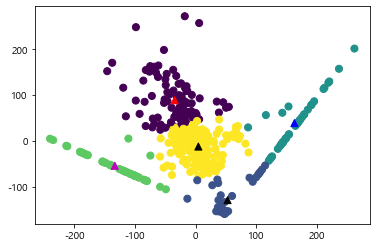

In [46]:
#스케일 안한 데이터 시각화
plt.scatter(school_pca_frm['pca_x'], school_pca_frm['pca_y'], #좌표 값은 처음 군집화했던 값
            marker='o',
            c = school_kmeans.labels_,  # 색 구분은 클러스터 아이디 사용
           s = 50)
plt.scatter(school_kmeans_center.cluster_centers_[ : , 0], #센터 마커
            school_kmeans_center.cluster_centers_[ :, 1], #센터 값으로 군집화했던 값 사용
            marker='^',
            c = ['red', 'k', 'black', 'm', 'blue'],
           s = 50)

plt.show()
plt.close()

In [67]:
groups = school_frm.groupby(['cid'])['학교명']
groups.describe()

,count,unique,top,freq
cid,,,,
0,100,100,개원중학교,1
1,43,43,공진중학교,1
2,42,42,서울대학교사범대학부설여자중학교,1
3,49,49,서울대학교사범대학부설중학교,1
4,181,181,개포중학교,1


In [95]:
#데이터 프레임에서 클러스터 아이디를 기준으로 그룹화
groups_test = school_frm.groupby(['cid'])[['학교명', '위도', '경도']]
dict(list(groups_test))[4]['학교명']

5

In [106]:
import folium
school_map = folium.Map(location=[37.51866293413177, 126.95911733710076],
                       zoom_start=12,
                       tiles="Stamen Toner")

#------------------------0번--------------------------------
for name, lat, lng in zip(dict(list(groups_test))[0]['학교명'],
                          dict(list(groups_test))[0]['위도'],
                          dict(list(groups_test))[0]['경도']):
    folium.CircleMarker(
                    [lat, lng],
                    radius=10,         # 원의 반지름
                    color='white',     # 원의 둘레 색상
                    fill=True,
                    fill_color='green', # 원을 채우는 색
                    fill_opacity=0.7, # 투명도
                    popup=name).add_to(school_map)
    
    
#------------------------1번--------------------------------
for name, lat, lng in zip(dict(list(groups_test))[1]['학교명'],
                          dict(list(groups_test))[1]['위도'],
                          dict(list(groups_test))[1]['경도']):
    folium.CircleMarker(
                    [lat, lng],
                    radius=10,         # 원의 반지름
                    color='black',     # 원의 둘레 색상
                    fill=True,
                    fill_color='red', # 원을 채우는 색
                    fill_opacity=0.5, # 투명도
                    popup=name).add_to(school_map)
    
    
#------------------------2번--------------------------------
for name, lat, lng in zip(dict(list(groups_test))[2]['학교명'],
                          dict(list(groups_test))[2]['위도'],
                          dict(list(groups_test))[2]['경도']):
    folium.CircleMarker(
                    [lat, lng],
                    radius=10,         # 원의 반지름
                    color='white',     # 원의 둘레 색상
                    fill=True,
                    fill_color='blue', # 원을 채우는 색
                    fill_opacity=0.7, # 투명도
                    popup=name).add_to(school_map)
    
    
#------------------------3번--------------------------------
for name, lat, lng in zip(dict(list(groups_test))[3]['학교명'],
                          dict(list(groups_test))[3]['위도'],
                          dict(list(groups_test))[3]['경도']):
    folium.CircleMarker(
                    [lat, lng],
                    radius=10,         # 원의 반지름
                    color='white',     # 원의 둘레 색상
                    fill=True,
                    fill_color='brown', # 원을 채우는 색
                    fill_opacity=0.9, # 투명도
                    popup=name).add_to(school_map)
    
    
#------------------------4번--------------------------------
for name, lat, lng in zip(dict(list(groups_test))[4]['학교명'],
                          dict(list(groups_test))[4]['위도'],
                          dict(list(groups_test))[4]['경도']):
    folium.CircleMarker(
                    [lat, lng],
                    radius=10,         # 원의 반지름
                    color='white',     # 원의 둘레 색상
                    fill=True,
                    fill_color='purple', # 원을 채우는 색
                    fill_opacity=0.9, # 투명도
                    popup=name).add_to(school_map)    



    
school_map.save('data/middle_shcool_graduates.html')
school_map